# Uso de Twitter en periódos electorales

## Reporte sobre internas de la ANR, Diciembre 2017

## Recolección de tweets basada en cuentas (@) y Hashtags (#)

Usando el API de Twitter recoletamos **tweets publicados entre el 27 de Noviembre 2017 y el 15 de Enero de 2018**, que provengan de cuentas de pre-candidatos de los principales partidos políticos (ANR), y/o contengan hashtags utilizados con fines electorales. Como base utilizamos las cuentas y hashtags publicados por el Diario Última Hora en su artículo [Perfiles de pre-candidatos según las redes](http://elecciones.ultimahora.com/informacion/?id=20). Por ejemplo, Última Hora reporta que el hashtag **#JuntosPodemosMas** es utilizado para identificar tweets vínculados al candidatos Santiago Peña de Honor Colorado. Así mismo, **#MaritoDeLaGente** se utilzan en tweets publicados en favor del candidato del movimiento Colorado Añeteté.

[Aquí](https://docs.google.com/spreadsheets/d/e/2PACX-1vQHoukfR9AFhSaz30QHYwKqpwexe1ASrW8ya25Fueh3jXcRPMSjrAyj4SbzryTLiuKkPdi6fsprqtM2/pubhtml) se puede acceder a lista completa de hashtags y cuentas.

## Tamaño del data set

In [1]:
%matplotlib inline

import os
import csv
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

os.chdir('..')

from datetime import datetime
from db_manager import *
from data_wrangler import *

plt.style.use('seaborn')

In [2]:
db = DBManager('tweets')
total_tweets = db.search({'flag.partido_politico.anr': {'$gt': 0}}, only_relevant_tws=False).count()
print('Se recolectaron {0} tweets relacionados a la interna de la ANR'.format(total_tweets))

Se recolectaron 178860 tweets relacionados a la interna de la ANR


## Selección de tweets relevantes

Encontramos que los hashtags usados por los candidatos en sus campañas era también utilizados en otros contextos (en otros paises) por lo tanto para el estudio consideramos solo aquellos tweets que además de los hashtags de interés contienen alguna mención a cuentas de los candidatos.

In [3]:
te = TweetEvaluator()
te.identify_relevant_tweets()
relevant_tweets = db.search({'flag.partido_politico.anr': {'$gt': 0}, 'relevante': 1}).count()
per_relevant = round(100*(relevant_tweets/total_tweets),0)
print('Del total de {0} tweets con hashtags relacionados a la campaña de la ANR, seleccionamos {1} que encontramos ' \
      'relevantes para el trabajo ({2}% del total)'.
      format(total_tweets,relevant_tweets, per_relevant))

Del total de 178860 tweets con hashtags relacionados a la campaña de la ANR, seleccionamos 145021 que encontramos relevantes para el trabajo (81.0% del total)


## Número de perfiles autores de tweets

In [4]:
unique_tw_authors = db.get_unique_users(**{'partido':'anr'})

In [6]:
print('En total {0} perfiles publicaron tweets relacionados a las internas del partido colorado'.format(len(unique_tw_authors)))

En total 24449 perfiles publicaron tweets relacionados a las internas del partido colorado


## Tipo de tweets

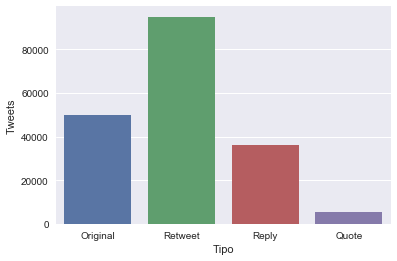

In [7]:
num_original_tweets = db.search({'flag.partido_politico.anr': {'$gt': 0}, 
                                 'tweet_obj.retweeted_status': {'$exists': 0}}).count()
num_retweets = db.search({'flag.partido_politico.anr': {'$gt': 0}, 
                          'tweet_obj.retweeted_status': {'$exists': 1}}).count()
num_replies = db.search({'flag.partido_politico.anr': {'$gt': 0}, 
                          'tweet_obj.in_reply_to_status_id_str': {'$ne': None}}).count()
num_quotes = db.search({'flag.partido_politico.anr': {'$gt': 0}, 
                        'tweet_obj.quoted_status_id': {'$ne': None}}).count()
tweets_por_tipo = pd.DataFrame({
    'Tipo': ['Original', 'Retweet', 'Reply', 'Quote'],
    'Tweets': [num_original_tweets, num_retweets, num_replies, num_quotes]
}, index=['ot', 'rt', 'rp', 'qt'])
fig = sns.barplot(x='Tipo', y='Tweets', data=tweets_por_tipo)
plt.show()

In [8]:
print('Se publicaton {0} tweets originales'.format(num_original_tweets))
print('Se publicaton {0} retweets'.format(num_retweets))
print('Se publicaton {0} replies'.format(num_replies))
print('Se publicaton {0} quotes'.format(num_quotes))

Se publicaton 50027 tweets originales
Se publicaton 94994 retweets
Se publicaton 36364 replies
Se publicaton 5587 quotes


## Evolución de tweets en el tiempo

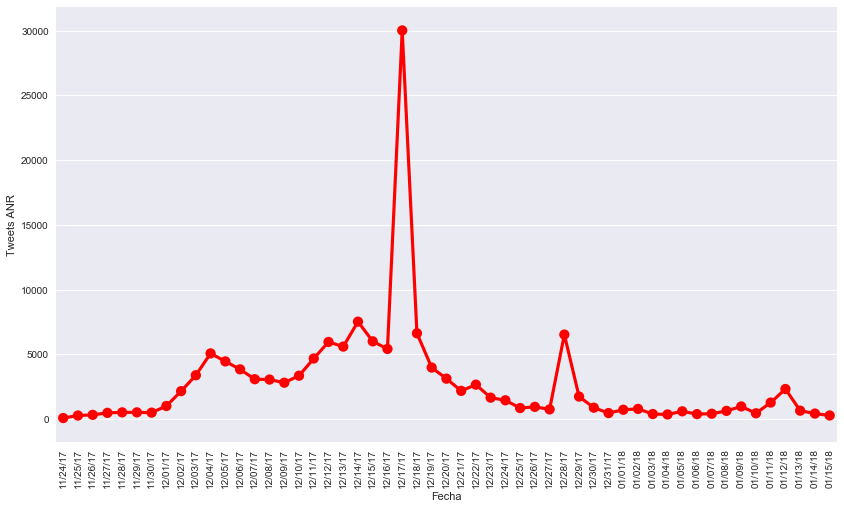

In [9]:
# set figure size
plt.figure(figsize=(14,8))
# get tweets by date
tw_by_date = db.get_tweets_by_date(**{'partido':'anr'})
# convert list to pandas' dataframe
tweets_por_fecha = pd.DataFrame(tw_by_date)
# draw and show the figure
fig = sns.pointplot(x='_id', y='count', data=tweets_por_fecha, color="red")
fig.set(xlabel='Fecha', ylabel='Tweets ANR')
for item in fig.get_xticklabels():
    item.set_rotation(90)
plt.show()

La publicación de tweets fue creciendo con el paso del tiempo. El día de las elecciones (**`17 de diciembre`**) se concentró el mayor de publicaciones de tweets, más de **`30.000`** tweets se publicaron ese día. Pasadas las elecciones los tweets relacionados a las internas decrecieron significativamente con un pequeño pico el día de 28 de diciembre. Esto pudo haberse debido a que ese día el presidente de la república y líder del Movimiento Honor Colorado, Horacio Cartes, confirmó su reunión con Mario Abdo Benítez, líder de Colorado Añeteté, en busca de la unidad del Partido Colorado ([Cartes confirma abrazo republicano](http://www.abc.com.py/nacionales/cartes-confirma-abrazo-republicano-1662344.html)).

## Distribución de Tweets por movimiento

Exploraremos la distribución de tweets considerando los dos movimiento más importantes en estas internas, es decir **`Honor Colorado`** y **`Colorado Añeteté`**.

### Honor Colorado

In [28]:
tweets_hc = db.search({'flag.movimiento.honor colorado': {'$gt': 0}, 
                       'flag.movimiento.colorado añetete': {'$eq': 0},
                       'relevante': 1})
print('Se publicaron {0} tweets relacionados al movimiento Honor Colorado ({1}% del total)'.
      format(tweets_hc.count(), round((tweets_hc.count()/relevant_tweets)*100,2)))

Se publicaron 86245 tweets relacionados al movimiento Honor Colorado (59.47% del total)


### Colorado Añeteté

In [27]:
tweets_ca = db.search({'flag.movimiento.colorado añetete': {'$gt': 0},
                       'flag.movimiento.honor colorado': {'$eq': 0},
                       'relevante': 1})
print('Se publicaron {0} tweets relacionados al movimiento Colorado Añetete ({1}% del total)'.
      format(tweets_ca.count(), round((tweets_ca.count()/relevant_tweets)*100,2)))

Se publicaron 46760 tweets relacionados al movimiento Colorado Añetete (32.24% del total)


### Ambos

In [26]:
tweets_hc_ca = db.search({'flag.movimiento.colorado añetete': {'$gt': 0},
                          'flag.movimiento.honor colorado': {'$gt': 0},
                          'relevante': 1})
print('Se publicaron {0} tweets relacionados a ambos movimientos ({1}% del total)'.
      format(tweets_hc_ca.count(), round((tweets_hc_ca.count()/relevant_tweets)*100,2)))

Se publicaron 10917 tweets relacionados a ambos movimientos (7.53% del total)


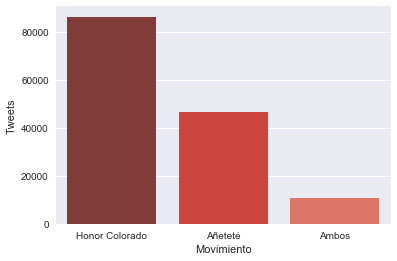

In [29]:
tweets_por_movimiento = pd.DataFrame({
    'Movimiento': ['Honor Colorado', 'Añeteté', 'Ambos'],
    'Tweets': [tweets_hc.count(), tweets_ca.count(), tweets_hc_ca.count()]
}, index=['hc', 'ca', 'ambos'])
fig = sns.barplot(x='Movimiento', y='Tweets', data=tweets_por_movimiento, palette="Reds_d")
plt.show()

Los tweets relacionados al movimiento **`Honor Colorado`** constituyen casi el **`60%`** de nuestro data set mientras que los vinculados a las candidaturas del movimiento **`Colorado Añeteté`** representan menos del **`35%`** del total de datos. El restante porcentaje se distribuye entre tweet que hacen referencia a ambos movimiento (7%) y tweets vínculados a las internas de la ANR pero no necesariamente a alguno de estos dos movimiento, por ejemplo, tweets que utilizan solamente el hashtag **`#InternasANR`**.

### Distribución de tweets por hora el día D (17/12/17)

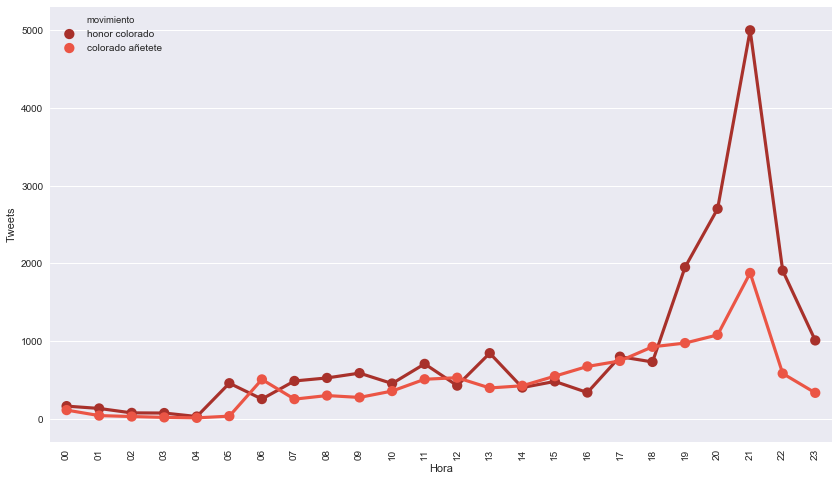

In [15]:
# set figure size
plt.figure(figsize=(14,8))
# get tweets by hour by movement
hc_tw_by_hour = db.get_tweets_by_hour('12/17/17', **{'partido': 'anr','movimiento': 'honor colorado'})
ca_tw_by_hour = db.get_tweets_by_hour('12/17/17', **{'partido': 'anr','movimiento': 'colorado añetete'})
# convert list to pandas' dataframe
tweets_by_hour = pd.DataFrame(hc_tw_by_hour)
tweets_by_hour = tweets_by_hour.append(pd.DataFrame(ca_tw_by_hour))
# draw and show the figure
fig = sns.pointplot(x='hour', y='count', data=tweets_by_hour, hue="movimiento", 
                    palette="Reds_d")
fig.set(xlabel='Hora', ylabel='Tweets')
for item in fig.get_xticklabels():
    item.set_rotation(90)
plt.show()

La cantidad de tweets con información relacionada a **`Honor Colorado`** fue superior durante toda la jornada electoral con respecto a los tweets de **`Colorado Añeteté`**

## Distribución de tweets por candidato

Para esta parte del análisis solo se tuvieron en cuenta los tweets que contienen hashtags relacionados a la figura del **candidato**, no del **movimiento** o **partido** al que este pertenece. Por ejemplo, los hashtags **`#JuntosPodemosMas`** o **`#CaminandoJuntos`** son hashtags vinculados principalmente a la figura de Santiago Peña no así el hashtag **`#HonorColorado`** que se utiliza para referirse al movimiento partidario pero no necesariamente la candidatura de Peña.

En los siguientes análisis no se tendrán en cuenta los tweets publicados por los candidatos personalmente.

### Santiago Peña

Hashtags de ejemplo: `#JuntosPodemosMas`, `#CaminandoJuntos`, `#SantiPresidente`, `#VotoxSanti`, `#SigamosConversando`

In [39]:
tweets_sp = db.search({'flag.candidatura.santiago peña': {'$gt': 0},
                       'flag.candidatura.mario abdo': {'$eq': 0},
                       'tweet_obj.user.screen_name': {'$ne': 'SantiPenap'},
                       'relevante': 1})
print('Se publicaron {0} tweets relacionados utilizando hashtags vinculados a la candidatura de Santiago Peña ' \
      '({1}% del total de los tweets de Honor Colorado)'.
      format(tweets_sp.count(), round((tweets_sp.count()/tweets_hc.count())*100,2)))

Se publicaron 58332 tweets relacionados utilizando hashtags vinculados a la candidatura de Santiago Peña (67.64% del total de los tweets de Honor Colorado)


### Mario Abdo Benítez

Hashtags de ejemplo: `#MaritoDeLaGente`, `#ParaguayDeLaGente`

In [11]:
q_ma = {'candidatura': 'mario abdo', 'tweet_obj.user.screen_name': {'$eq':'MaritoAbdo'}}
tweets_ma = db.search(q_ma)
print('Tweets de Mario Abdo: {0}'.format(tweets_ma.count()))

Tweets de Mario Abdo: 230


In [12]:
q_mov_ca = {'movimiento': 'colorado añetete', 'tweet_obj.user.screen_name': {'$ne':'MaritoAbdo'}}
tweets_mov_ca = db.search(q_mov_ca)
print('Tweets del movimiento Colorado Añetete: {0}'.format(tweets_mov_ca.count()))

Tweets del movimiento Colorado Añetete: 60411


In [13]:
q_nma = {'candidatura': 'mario abdo', 'tweet_obj.user.screen_name': {'$ne':'MaritoAbdo'}}
tweets_ma = db.search(q_nma)
print('Tweets relacionados al candidato Mario Abdo: ' \
      '{0} ({1}% del total del movimiento Colorado Añeteté)'.format(tweets_ma.count(), 
                                                      round((tweets_ma.count()/tweets_mov_ca.count())*100,2)))

Tweets relacionados al candidato Mario Abdo: 44741 (74.06% del total del movimiento Colorado Añeteté)


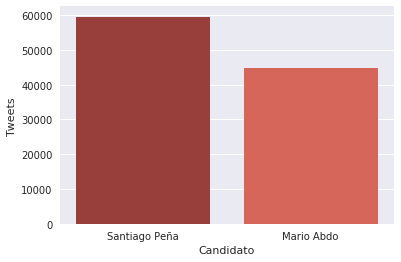

In [14]:
tweets_por_candidato_anr = pd.DataFrame({
    'Candidato': ['Santiago Peña', 'Mario Abdo'],
    'Tweets': [tweets_sp.count(),tweets_ma.count()]
}, index=['sp', 'ma'])
sns.barplot(x='Candidato', y='Tweets', data=tweets_por_candidato_anr, palette="Reds_d")

## Hashtags más populares usados por los candidatos

### Santiago Peña

In [6]:
additional_args = {'include_candidate':False, 'candidate_handler':'SantiPenap'}
hashtags_hc = db.get_hashtags_by_candidate('santiago peña', **additional_args)
hashtags_populares_hc = []
sum_total = 0
for i in range(5):
    hashtag = hashtags_hc[i]
    sum_total += hashtag['count']
    hashtag_dict = {'1. Hashtag': '#' + hashtag['_id'], '2. Cantidad de Tweets': hashtag['count']}
    hashtags_populares_hc.append(hashtag_dict)
pd.DataFrame(hashtags_populares_hc)

,1. Hashtag,2. Cantidad de Tweets
0,#SantiPresidente,8058
1,#VotoxSanti,4003
2,#SigamosConversando,1588
3,#HonorColorado,929
4,#Lista2,694


### Mario Abdo

In [5]:
additional_args = {'include_candidate':False, 'candidate_handler':'MaritoAbdo'}
hashtags_ca = db.get_hashtags_by_candidate('mario abdo', **additional_args)
hashtags_populares_ca = []
for i in range(5):
    hashtag = hashtags_ca[i]
    hashtag_dict = {'1. Hashtag': '#' + hashtag['_id'], '2. Cantidad de Tweets': hashtag['count']}
    hashtags_populares_ca.append(hashtag_dict)
pd.DataFrame(hashtags_populares_ca)

,1. Hashtag,2. Cantidad de Tweets
0,#ParaguayDeLaGente,10578
1,#MaritoDeLaGente,2014
2,#Lista3,737
3,#ColoradoAñetete,489
4,#MaritoPresidente,358


### Efraín Alegre

In [50]:
additional_args = {'include_candidate':False, 'candidate_handler':'EfrainAlegre'}
hashtags_ea_1 = db.get_hashtags_by_candidate('efrain alegre', **additional_args)
hashtags_ea_2 = db.get_hashtags_by_candidate('efrain alegre\n', **additional_args)
hashtags_populares_ea = []
hashtag_dict_by_keyword = {}
for i in range(2):
    hashtag = hashtags_ea_1[i]
    key = hashtag['_id'];
    hashtag_dict_by_keyword[key] = {'key': key, 'count': hashtag['count']}
    
for i in range(2):
    hashtag = hashtags_ea_2[i]
    key = hashtag['_id'];
    if key in hashtag_dict_by_keyword:
        current_count = hashtag_dict_by_keyword[key]['count']
        hashtag_dict_by_keyword[key] = {'key': key, 'count': current_count+hashtag['count']}
    else:
        hashtag_dict_by_keyword[key] = {'key': key, 'count': hashtag['count']}

for key in hashtag_dict_by_keyword:
    hashtag = hashtag_dict_by_keyword[key]
    hashtag_dict = {'1. Hashtag': '#' + hashtag['key'], '2. Cantidad de Tweets': hashtag['count']}
    hashtags_populares_ea.append(hashtag_dict)
    
pd.DataFrame(hashtags_populares_ea)

,1. Hashtag,2. Cantidad de Tweets
0,#VamosAGanarTodos,8
1,#InternasPLRA,2
2,#EsAhora,211


### Carlos Mateo Balmelli 

In [54]:
additional_args = {'include_candidate':False, 'candidate_handler':'CARLOSMATEOPY'}
hashtags_ea_1 = db.get_hashtags_by_candidate('carlos mateo balmelli', **additional_args)
hashtags_ea_2 = db.get_hashtags_by_candidate('carlos mateo balmelli\n', **additional_args)
hashtags_populares_ea = []
hashtag_dict_by_keyword = {}
for i in range(1):
    hashtag = hashtags_ea_1[i]
    key = hashtag['_id'];
    hashtag_dict_by_keyword[key] = {'key': key, 'count': hashtag['count']}
    
for i in range(1):
    hashtag = hashtags_ea_2[i]
    key = hashtag['_id'];
    if key in hashtag_dict_by_keyword:
        current_count = hashtag_dict_by_keyword[key]['count']
        hashtag_dict_by_keyword[key] = {'key': key, 'count': current_count+hashtag['count']}
    else:
        hashtag_dict_by_keyword[key] = {'key': key, 'count': hashtag['count']}

for key in hashtag_dict_by_keyword:
    hashtag = hashtag_dict_by_keyword[key]
    hashtag_dict = {'1. Hashtag': '#' + hashtag['key'], '2. Cantidad de Tweets': hashtag['count']}
    hashtags_populares_ea.append(hashtag_dict)
    
pd.DataFrame(hashtags_populares_ea)

,1. Hashtag,2. Cantidad de Tweets
0,#VotáLista7,392


## Cantidad de tuiteros por movimiento

### Honor Colorado

In [8]:
additional_args = {'include_candidate':False, 'candidate_handler':'SantiPenap', 'movimiento':'honor colorado'}
unique_users_hc = db.get_unique_users(**additional_args)
print('{0} usuarios tuitearon sobre Honor Colorado'.format(len(unique_users_hc)))

20505 usuarios tuitearon sobre Honor Colorado


#### Top-10 más activos con sus actividades

In [9]:
top10_tuiteros_hc = []
for i in range(10):
    tuitero_hc = {'1.Usuario': unique_users_hc[i]['screen_name'], 
                  '2.Tweets': unique_users_hc[i]['tweets_count'],
                  '3.Originales': unique_users_hc[i]['original_count'],
                  '4.Retweets': unique_users_hc[i]['retweets_count'],
                  '5.Quotes': unique_users_hc[i]['quotes_count'],
                  '6.Replies': unique_users_hc[i]['replies_count'],
                  '7.Followers': unique_users_hc[i]['followers'],
                  '8.Friends': unique_users_hc[i]['friends']}
    top10_tuiteros_hc.append(tuitero_hc)
pd.DataFrame(top10_tuiteros_hc)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,CESARSANCHEZ553,869,0,589,0,280,17,132
1,ArturoO22734057,822,1,816,0,5,192,825
2,Michelec1954,809,0,0,674,135,708,1484
3,Norabeli,756,0,565,2,189,1387,930
4,delgapy2016,732,0,703,0,29,79,461
5,CesarSanchez636,538,0,399,0,139,155,651
6,Mariade84654356,536,0,536,0,0,12,80
7,machaparro48,525,0,380,0,145,928,886
8,gladysgulino,489,0,489,0,0,471,93
9,AngelicaZunilda,489,0,232,0,257,124,50


### Colorado Añeteté

In [10]:
additional_args = {'include_candidate':False, 'candidate_handler':'MaritoAbdo', 'movimiento':'colorado añetete'}
unique_users_ca = db.get_unique_users(**additional_args)
print('{0} usuarios tuitearon sobre Colorado Anetete'.format(len(unique_users_ca)))

10047 usuarios tuitearon sobre Colorado Anetete


#### Top-10 más activos y sus actividades

In [11]:
top10_tuiteros_ca = []
for i in range(10):
    tuitero_ca = {'1.Usuario': unique_users_ca[i]['screen_name'], 
                  '2.Tweets': unique_users_ca[i]['tweets_count'],
                  '3.Originales': unique_users_ca[i]['original_count'],
                  '4.Retweets': unique_users_ca[i]['retweets_count'],
                  '5.Quotes': unique_users_ca[i]['quotes_count'],
                  '6.Replies': unique_users_ca[i]['replies_count'],
                  '7.Followers': unique_users_ca[i]['followers'],
                  '8.Friends': unique_users_ca[i]['friends']}
    top10_tuiteros_ca.append(tuitero_ca)
pd.DataFrame(top10_tuiteros_ca)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,Paraguaynosune,1332,0,1332,0,0,520,174
1,Solmelga,690,208,413,1,68,5323,4790
2,Beatriz20D,669,0,612,0,57,210,739
3,jjrios_bogado,447,54,391,0,2,1870,777
4,EDITHVILLA3,427,11,324,0,92,598,1117
5,grfzp7771,408,4,342,0,62,39,369
6,felixugarte,403,0,399,0,4,499,369
7,Rogerlopez1980,363,0,357,0,6,93,375
8,LaJusticierra,349,2,336,0,11,3344,1262
9,EmanoelQuiroga,339,56,281,0,2,33,134


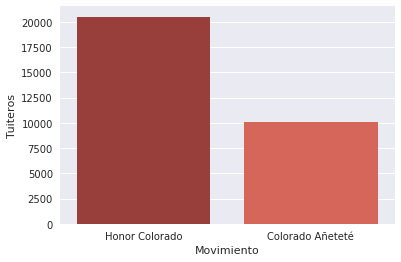

In [12]:
tuiteros_por_movimiento = pd.DataFrame({
    'Movimiento': ['Honor Colorado', 'Colorado Añeteté'],
    'Tuiteros': [len(unique_users_hc), len(unique_users_ca)]
}, index=['hc', 'ca'])
sns.barplot(x='Movimiento', y='Tuiteros', data=tuiteros_por_movimiento, palette="Reds_d")

Como se podría esperar el ejercito de tuiteros del movimiento *Honor Colorado* es ampliamente superior al de *Colorado Añeteté*. Prácticamente, **por cada tuitero de *Colorado Añeteté* existen casi 2.5 tuiteros de *Honor Colorado***. La diferencia en la cantidad de tuiteros se puede percibir también en la cantidad de tweets de cada movimiento; Honor Colorado tiene casi el doble de tweets que Colorado Añeteté.

Otro aspecto destacable del último análisis es el tipo de actividad que realizan tanto los tuiteros de *Honor Colorado* como los de *Añeteté*. En ambos casos, **los tuiteros más activos no publican nuevo tweets** sino se limitan a casi exclusivamente a retuitear tweets vinculados a su movimiento. En otras palabras, la principal actividad de estos usuarios es amplificar y promocionar información relacionada a sus intereses. **Este comportamiento es típico de bots y cuentas falsas**. La siguiente tarea en el estudio consistirá, por lo tanto, en análizar más en detalle el comportamiento de estas cuentas con el objetivo de verificar si son falsas o se encuentran vínculadas a sistemas automáticos de publicaciones. 

## Cantidad de tuiteros por candidatura

### Santiago Peña

In [13]:
additional_args = {'include_candidate':False, 'candidate_handler':'SantiPenap', 'candidatura':'santiago peña'}
unique_users_sp = db.get_unique_users(**additional_args)
print('{0} usuarios tuitearon sobre Santiago Peña'.format(len(unique_users_sp)))

14917 usuarios tuitearon sobre Santiago Peña


#### Top-10 más activos con sus actividades

In [15]:
top10_tuiteros_sp = []
for i in range(10):
    tuitero_sp = {'1.Usuario': unique_users_sp[i]['screen_name'], 
                  '2.Tweets': unique_users_sp[i]['tweets_count'],
                  '3.Originales': unique_users_sp[i]['original_count'],
                  '4.Retweets': unique_users_sp[i]['retweets_count'],
                  '5.Quotes': unique_users_sp[i]['quotes_count'],
                  '6.Replies': unique_users_sp[i]['replies_count'],
                  '7.Followers': unique_users_sp[i]['followers'],
                  '8.Friends': unique_users_sp[i]['friends']}
    top10_tuiteros_sp.append(tuitero_sp)
pd.DataFrame(top10_tuiteros_sp)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,CESARSANCHEZ553,482,0,343,0,139,20,147
1,SemideiOmar,383,8,1,0,374,421,284
2,CesarSanchez636,360,0,257,0,103,155,651
3,Norabeli,349,0,252,0,97,1390,933
4,ArturoO22734057,345,1,341,0,3,196,833
5,delgapy2016,269,0,258,0,11,82,462
6,Radio970AM,240,26,3,1,210,212055,878
7,guidoschultz73,223,0,184,0,39,175,259
8,machaparro48,209,0,137,0,72,929,886
9,AngelicaZunilda,201,0,82,0,119,132,50


### Mario Abdo

In [16]:
additional_args = {'include_candidate':False, 'candidate_handler':'MaritoAbdo', 'candidatura':'mario abdo'}
unique_users_ma = db.get_unique_users(**additional_args)
print('{0} usuarios tuitearon sobre Mario Abdo'.format(len(unique_users_ma)))

9834 usuarios tuitearon sobre Mario Abdo


#### Top-10 más activos y sus actividades

In [17]:
top10_tuiteros_ma = []
for i in range(10):
    tuitero_ma = {'1.Usuario': unique_users_ma[i]['screen_name'], 
                  '2.Tweets': unique_users_ma[i]['tweets_count'],
                  '3.Originales': unique_users_ma[i]['original_count'],
                  '4.Retweets': unique_users_ma[i]['retweets_count'],
                  '5.Quotes': unique_users_ma[i]['quotes_count'],
                  '6.Replies': unique_users_ma[i]['replies_count'],
                  '7.Followers': unique_users_ma[i]['followers'],
                  '8.Friends': unique_users_ma[i]['friends']}
    top10_tuiteros_ma.append(tuitero_ma)
pd.DataFrame(top10_tuiteros_ma)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,Paraguaynosune,739,0,739,0,0,521,175
1,Beatriz20D,498,0,449,0,49,209,738
2,Solmelga,429,119,255,1,54,5345,4793
3,felixugarte,251,0,247,0,4,502,369
4,Norabeli,235,1,189,1,44,1390,933
5,jjrios_bogado,232,26,204,0,2,1871,780
6,CESARSANCHEZ553,214,0,204,0,10,20,147
7,EDITHVILLA3,212,4,167,0,41,599,1117
8,EmanoelQuiroga,209,38,170,0,1,33,134
9,Rogerlopez1980,196,0,193,0,3,93,376


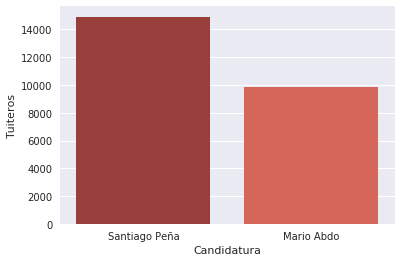

In [22]:
tuiteros_por_candidatura_anr = pd.DataFrame({
    'Candidatura': ['Santiago Peña', 'Mario Abdo'],
    'Tuiteros': [len(unique_users_sp), len(unique_users_ma)]
}, index=['sp', 'ma'])
sns.barplot(x='Candidatura', y='Tuiteros', data=tuiteros_por_candidatura_anr, palette="Reds_d")

### Efrain Alegre

In [5]:
additional_args = {'include_candidate':False, 'candidate_handler':'EfrainAlegre', 'candidatura':'efrain alegre'}
unique_users_ea_1 = db.get_unique_users(**additional_args)
additional_args = {'include_candidate':False, 'candidate_handler':'EfrainAlegre', 'candidatura':'efrain alegre\n'}
unique_users_ea_2 = db.get_unique_users(**additional_args)
print('{0} usuarios tuitearon sobre Efrain Alegre'.format(len(unique_users_ea_1)+len(unique_users_ea_2)))

3004 usuarios tuitearon sobre Efrain Alegre


#### Top-10 más activos y sus actividades

In [7]:
top10_tuiteros_ea = []
# ToDo: merge lists or clean database
unique_users_ea = unique_users_ea_1
for i in range(10):
    tuitero_ea = {'1.Usuario': unique_users_ea[i]['screen_name'], 
                  '2.Tweets': unique_users_ea[i]['tweets_count'],
                  '3.Originales': unique_users_ea[i]['original_count'],
                  '4.Retweets': unique_users_ea[i]['retweets_count'],
                  '5.Quotes': unique_users_ea[i]['quotes_count'],
                  '6.Replies': unique_users_ea[i]['replies_count'],
                  '7.Followers': unique_users_ea[i]['followers'],
                  '8.Friends': unique_users_ea[i]['friends']}
    top10_tuiteros_ea.append(tuitero_ea)
pd.DataFrame(top10_tuiteros_ea)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,algoandamalpy,90,89,0,0,1,71674,524
1,c10arguello,47,0,35,0,12,587,3133
2,alebogado7902,46,0,14,0,32,2199,2166
3,LaUnionAM800,43,41,2,0,0,42560,280
4,fran_rat,39,1,11,3,24,517,657
5,desimasi2,37,6,8,5,18,27285,400
6,CesarSanchez636,36,0,33,0,3,156,651
7,JacquiSachelar1,36,1,19,4,12,279,343
8,ABCCardinal,35,35,0,0,0,183553,890
9,juankilezcano,32,21,8,0,3,7119,4742


### Carlos Mateo Balmelli

In [9]:
additional_args = {'include_candidate':False, 'candidate_handler':'CARLOSMATEOPY', 'candidatura':'carlos mateo balmelli'}
unique_users_mb_1 = db.get_unique_users(**additional_args)
additional_args = {'include_candidate':False, 'candidate_handler':'CARLOSMATEOPY', 'candidatura':'carlos mateo balmelli\n'}
unique_users_mb_2 = db.get_unique_users(**additional_args)
print('{0} usuarios tuitearon sobre Carlos Mateo Balmelli'.format(len(unique_users_mb_1)+len(unique_users_mb_2)))

685 usuarios tuitearon sobre Carlos Mateo Balmelli


#### Top-10 más activos y sus actividades

In [10]:
top10_tuiteros_mb = []
unique_users_mb = unique_users_mb_1
for i in range(10):
    tuitero_mb = {'1.Usuario': unique_users_mb[i]['screen_name'], 
                  '2.Tweets': unique_users_mb[i]['tweets_count'],
                  '3.Originales': unique_users_mb[i]['original_count'],
                  '4.Retweets': unique_users_mb[i]['retweets_count'],
                  '5.Quotes': unique_users_mb[i]['quotes_count'],
                  '6.Replies': unique_users_mb[i]['replies_count'],
                  '7.Followers': unique_users_mb[i]['followers'],
                  '8.Friends': unique_users_mb[i]['friends']}
    top10_tuiteros_mb.append(tuitero_mb)
pd.DataFrame(top10_tuiteros_mb)

,1.Usuario,2.Tweets,3.Originales,4.Retweets,5.Quotes,6.Replies,7.Followers,8.Friends
0,FSilvaFacetti,91,23,67,0,1,3501,752
1,equipojovenpy,64,3,49,0,12,1454,488
2,AlexOlmedoA,33,0,31,0,2,750,1362
3,luma_careaga,25,0,24,0,1,767,941
4,Radio970AM,23,3,0,0,20,213025,877
5,lanzoni21,16,0,16,0,0,6,76
6,1000_am,15,7,0,0,8,93224,368
7,animelot,13,0,6,0,7,153,383
8,mcsantiliv,12,0,12,0,0,351,312
9,780AM,11,10,1,0,0,291746,1267


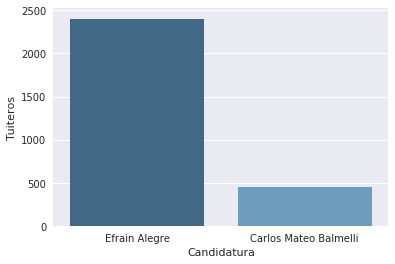

In [12]:
tuiteros_por_candidatura_plra = pd.DataFrame({
    'Candidatura': ['Efrain Alegre', 'Carlos Mateo Balmelli'],
    'Tuiteros': [len(unique_users_ea), len(unique_users_mb)]
}, index=['ea', 'mb'])
sns.barplot(x='Candidatura', y='Tuiteros', data=tuiteros_por_candidatura_plra, palette="Blues_d")

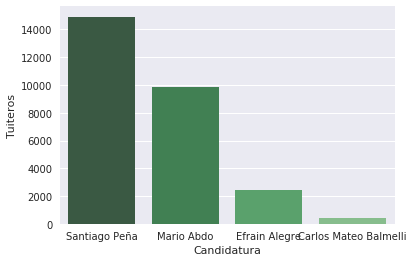

In [25]:
tuiteros_por_candidatura = pd.DataFrame({
    'Candidatura': ['Santiago Peña', 'Mario Abdo', 'Efrain Alegre', 'Carlos Mateo Balmelli'],
    'Tuiteros': [len(unique_users_sp), len(unique_users_ma),len(unique_users_ea), len(unique_users_mb)]
}, index=['sp','ma','ea', 'mb'])
sns.barplot(x='Candidatura', y='Tuiteros', data=tuiteros_por_candidatura, palette="Greens_d")